## GOAL

Analyze financial transaction data to predit if a particular transaction data is fraudulent.

In [118]:
import boto3

import numpy as np 
import pandas as pd
import os
from sklearn.utils import shuffle

region = boto3.Session().region_name    

bucket = 'anomaly-detection-team-vypin'                     
prefix = 'sagemaker/talasila'

---
## DOWNLOAD

In [119]:
s3 = boto3.resource('s3')
data_bucket = 'anomaly-detection-team-vypin'
data_key = 'PS_20174392719_1491204439457_log.csv'
s3.Bucket(data_bucket).download_file(data_key, 'input_data.csv')

Read data into a pandas dataframe

In [120]:
df = pd.read_csv('./input_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


---
## Analysis

bin transaction amounts into 50K range

In [121]:
# bin amounts into 50K range
bins = range(0, 1000000, 50000)
labels = range(0, 950000, 50000)
df['binned'] = pd.cut(df['amount'], bins=bins, labels=labels)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0


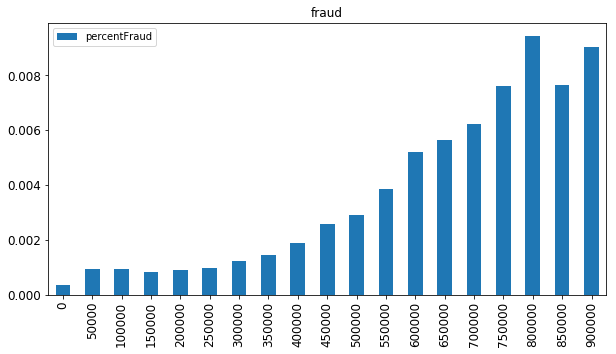

In [122]:
# analysis: set what percentage of tx in each bin is fraudulent

#df[['amount']].plot(kind='hist',bins=bins,rwidth=0.8)
adf1 = df['binned'].value_counts().to_frame('totalTx')
adf1['bin'] = adf1.index

fraud = df.loc[df['isFraud'] == 0].groupby(['binned']).size().to_frame('nonfraud')
adf1 = adf1.join(fraud, lsuffix='', rsuffix='', sort=False)
adf1['percentFraud'] = (adf1['totalTx'] - adf1['nonfraud'])/adf1['totalTx']

adf1[['bin','percentFraud']].plot(kind='bar', title ="fraud", figsize=(10, 5), legend=True, fontsize=12)



---
## MUNGING

In [123]:
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=['type'])
df = shuffle(df)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2823775,226,48228.06,C1964435730,0.00,0.00,M213324882,0.00,0.00,0,0,0,0,0,0,1,0
1608649,156,440260.79,C1276427568,66620.18,506880.96,C355900651,1997242.17,1556981.38,0,0,400000,1,0,0,0,0
1157112,131,29246.23,C899934233,0.00,0.00,M298249173,0.00,0.00,0,0,0,0,0,0,1,0
4446368,323,52578.36,C2075189766,237242.44,184664.08,M1162028936,0.00,0.00,0,0,50000,0,0,0,1,0
3773646,280,16283.30,C706293451,0.00,0.00,M774614297,0.00,0.00,0,0,0,0,0,0,1,0


Split data into the training, test and validation sets

In [146]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9*len(model_data))])  

train_data.to_csv('train_actual.csv', index=True, header=True)
validation_data.to_csv('validation_actual.csv', index=True, header=True)
test_data.to_csv('test_actual.csv', index=True, header=True)

train_data_munged = train_data.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)
validation_data_munged = validation_data.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)
test_data_munged = test_data.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)

train_data_munged.to_csv('train_munged.csv', index=False, header=False)
validation_data_munged.to_csv('validation_munged.csv', index=False, header=False)
test_data_munged.to_csv('test_munged.csv', index=False, header=False)

Copy to S3

In [147]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_actual.csv')).upload_file('train_actual.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_actual.csv')).upload_file('validation_actual.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_munged.csv')).upload_file('train_munged.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_munged.csv')).upload_file('validation_munged.csv')

---
## Training

In [149]:
import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import RandomCutForest
import pandas as pd

smclient = boto3.Session().client('sagemaker')
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket = 'anomaly-detection-team-vypin'                     
prefix = 'sagemaker/talasila'

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m5.12xlarge',
                      data_location='s3://{}/{}/train/train_munged.csv'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

training_data_set = pd.read_csv('s3://{}/{}/train/train_munged.csv'.format(bucket, prefix))

# run the training job on input data stored in S3
rcf.fit(rcf.record_set(training_data_set.as_matrix()))


INFO:sagemaker:Creating training-job with name: randomcutforest-2019-03-07-18-49-23-913


2019-03-07 18:49:24 Starting - Starting the training job...
2019-03-07 18:49:27 Starting - Launching requested ML instances......
2019-03-07 18:50:34 Starting - Preparing the instances for training......
2019-03-07 18:51:38 Downloading - Downloading input data
2019-03-07 18:51:38 Training - Downloading the training image...
2019-03-07 18:52:24 Uploading - Uploading generated training model
2019-03-07 18:52:24 Completed - Training job completed

Docker entrypoint called with argument(s): train
[03/07/2019 18:52:10 INFO 139622764631872] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[03/07/2019 

Billable seconds: 60


---
## Inference

Run inference for a small sample to test.

In [129]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-18-00-29-472
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-03-07-17-54-29-240


-------------------------------------------------------------------------!

In [130]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [131]:
train_data_munged_numpy = train_data_munged.as_matrix()
print(train_data_munged_numpy[:6])
results = rcf_inference.predict(train_data_munged_numpy[:6])
print(results)

[[1.50000000e+01 1.11715390e+05 6.00650000e+04 0.00000000e+00
  7.32142803e+06 7.43314342e+06 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.74000000e+02 1.24571810e+05 0.00000000e+00 0.00000000e+00
  4.21130120e+05 5.45701920e+05 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.38000000e+02 1.19280700e+04 1.04490000e+04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.83000000e+02 1.95802830e+05 9.97482838e+06 1.01706312e+07
  4.39853790e+05 2.44050960e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.01000000e+02 8.83495000e+03 3.74290000e+05 3.65455050e+05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [3.79000000e+02 8.52592000e+03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00

---
## Compute anomaly scores

Use batch transform to compute anomaly scores across the data set

In [150]:
import boto3
import sagemaker
import json

validation_munged_data_file = 's3://{}/{}/validation/validation_munged.csv'.format(bucket, prefix)
output_location = 's3://{}/{}/output/batch_transform'.format(bucket, prefix)

# Initialize the transformer object
transformer = rcf.transformer(
    instance_type='ml.c4.xlarge',
    instance_count=1,
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=output_location
    )
# Start a transform job
transformer.transform(validation_munged_data_file, content_type='text/csv', split_type='Line')
# Then wait until the transform job has completed
transformer.wait()

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-18-49-23-913
INFO:sagemaker:Creating transform job with name: randomcutforest-2019-03-07-18-56-30-686


..........................................................!


Download scores and join with the validation data set. Let's plot...

In [151]:
# Download validation results 
s3.Bucket(bucket).download_file(prefix + '/output/batch_transform/validation_munged.csv.out', 'validation_munged_out.csv')

In [152]:
with open('validation_munged_out.csv') as f:
    results = f.readlines()   
print(results[0])

{"score":0.5413483746}



In [153]:
scores = [json.loads(datum)['score'] for datum in results]

#add scores to validation data frame and print first few values
#m = np.asarray(scores)
validation_data['score'] = scores
validation_data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,score
2445937,203,124388.46,C895641742,3059.0,0.00,C1299188954,1190414.88,1611628.29,0,0,100000,0,1,0,0,0,0.541348
301450,15,110572.14,C183334974,1522.0,0.00,C2040474808,0.00,110572.14,0,0,100000,0,1,0,0,0,0.420956
1989547,179,169392.44,C1062740569,0.0,0.00,C1662206385,209127.80,378520.23,0,0,150000,0,1,0,0,0,0.428938
1909643,166,14315.23,C1971735805,130595.0,116279.77,M1325884062,0.00,0.00,0,0,0,0,0,0,1,0,0.404712
1786531,162,434957.09,C1058656014,398.0,0.00,C553456018,0.00,434957.09,0,0,400000,0,0,0,0,1,0.520071


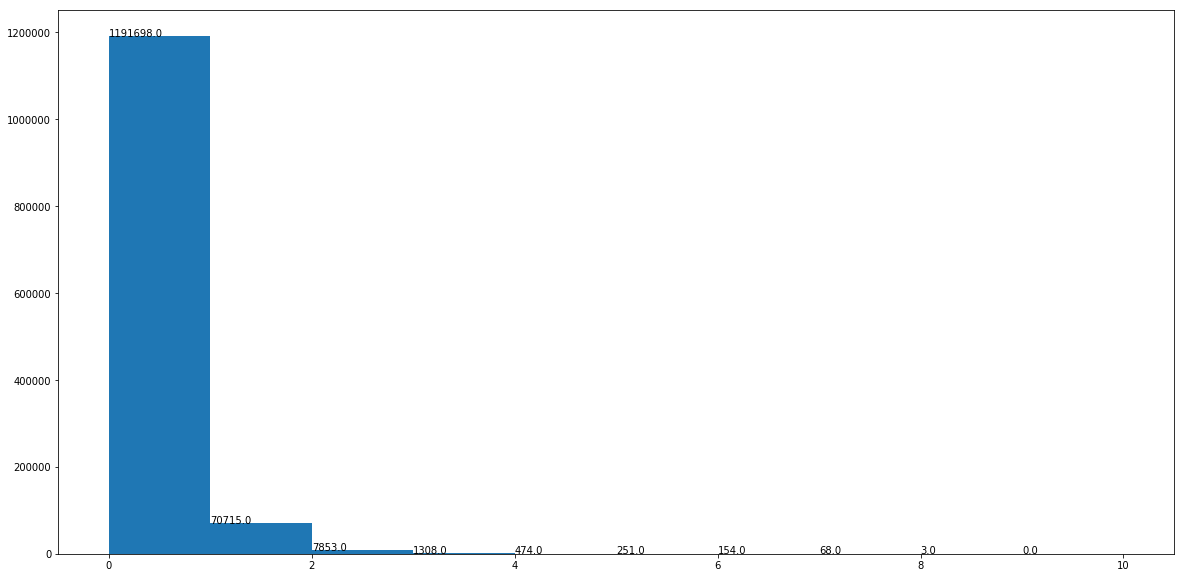

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
scores_bins = [0,1,2,3,4,5,6,7,8,9,10]
arr = plt.hist(scores, scores_bins)
for i in scores_bins:
    if i < len(scores_bins) - 1:
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))





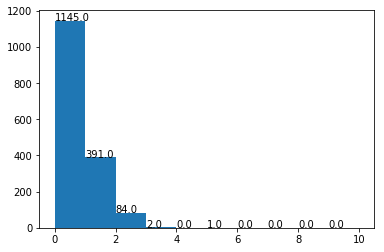

In [157]:
fraud_df = validation_data.loc[validation_data['isFraud'] == 1]

fraud_df

arr = plt.hist(fraud_df['score'], scores_bins)

for i in scores_bins:
    if i < len(scores_bins) - 1:
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))


In [161]:
validation_data.shape

(1272524, 17)

In [162]:
validation_data.loc[validation_data['isFraud'] == 1].shape

(1623, 17)

In [165]:
temp_df = validation_data.loc[validation_data['score'] > 5]
temp_df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,score
5407040,378,163333.23,C57854395,0.00,0.00,C256709103,9.365665e+07,9.381998e+07,0,0,150000.0,0,1,0,0,0,6.090081
4474109,324,24185366.55,C2034341245,0.00,0.00,C786847772,4.292952e+07,6.711488e+07,0,0,NaN,0,0,0,0,1,5.106271
4581038,328,154201.29,C1834983746,19341.00,173542.29,C907499666,1.747885e+08,1.746343e+08,0,0,150000.0,1,0,0,0,0,7.258171
4595562,328,141799.33,C628715392,80504.00,0.00,C1487890981,7.114256e+07,7.128436e+07,0,0,100000.0,0,1,0,0,0,5.378257
4873014,348,274017.55,C531551154,0.00,0.00,C872794128,7.325220e+07,7.352621e+07,0,0,250000.0,0,1,0,0,0,5.450223
4302276,307,64520.48,C1129887357,0.00,0.00,C1831361991,8.551877e+07,8.558329e+07,0,0,50000.0,0,1,0,0,0,5.855047
4349970,309,156555.44,C679416865,0.00,0.00,C2057039461,1.453128e+08,1.454693e+08,0,0,150000.0,0,0,0,0,1,6.971552
4094233,301,17708539.11,C294063973,0.00,0.00,C1640920899,1.135057e+08,1.312142e+08,0,0,NaN,0,0,0,0,1,6.739043
3972208,297,15137042.56,C329129505,0.00,0.00,C1105357919,7.308106e+07,8.821810e+07,0,0,NaN,0,0,0,0,1,5.839960
4147080,303,39552821.21,C2054597055,0.00,0.00,C1496190878,1.147095e+08,1.542623e+08,0,0,NaN,0,0,0,0,1,7.027761


In [166]:
temp_df = validation_data.loc[validation_data['score'] < 1]
temp_df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,score
2445937,203,124388.46,C895641742,3059.00,0.00,C1299188954,1190414.88,1611628.29,0,0,100000,0,1,0,0,0,0.541348
301450,15,110572.14,C183334974,1522.00,0.00,C2040474808,0.00,110572.14,0,0,100000,0,1,0,0,0,0.420956
1989547,179,169392.44,C1062740569,0.00,0.00,C1662206385,209127.80,378520.23,0,0,150000,0,1,0,0,0,0.428938
1909643,166,14315.23,C1971735805,130595.00,116279.77,M1325884062,0.00,0.00,0,0,0,0,0,0,1,0,0.404712
1786531,162,434957.09,C1058656014,398.00,0.00,C553456018,0.00,434957.09,0,0,400000,0,0,0,0,1,0.520071
1670960,158,143341.99,C295070837,693957.86,837299.86,C1765011918,3317439.03,3174097.03,0,0,100000,1,0,0,0,0,0.814795
175222,12,159209.28,C1870067282,4185.49,0.00,C1068446848,163213.14,322422.41,0,0,150000,0,1,0,0,0,0.421791
2850606,227,5892.78,C2114922657,70049.14,64156.35,M946310462,0.00,0.00,0,0,0,0,0,0,1,0,0.380228
2916685,229,35871.60,C1805871494,10570.00,0.00,M1604509769,0.00,0.00,0,0,0,0,0,0,1,0,0.351586
3472063,258,2674.33,C1053330117,0.00,0.00,M1223826874,0.00,0.00,0,0,0,0,0,0,1,0,0.296147
